In [50]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import interpolate
import seaborn as sns
sns.set()
import pandas as pd
import pickle

import theano.tensor as TT
import time
import random

import pymc3 as pm
import arviz as az

import sys
#import winsound

%run Bayes2.ipynb
%run /home/gordotony/Documents/GitHub/tesis/codigos/R_Fresnel.ipynb
%run /home/gordotony/Documents/GitHub/tesis/codigos/Pinel.ipynb
#%run r'C:\Users\Coraline\Documents\UWB\tesis\codigos\R_Fresnel.ipynb'
#%run r'C:\Users\Coraline\Documents\UWB\tesis\codigos\Pinel.ipynb'

In [51]:
PATH = sys.path[0]
print(PATH)

/home/gordotony/Documents/GitHub/tesis/Bayesiano/Ajustes


In [52]:
portadora = 'Fc8'

## Parámetros globales de la antena

Fs = 23.328e9 #Frecuencia de muestreo [Hz] 
Ts = 1/Fs
BW = 1.5e9 

corte = 150
Nfft= 1024 # nro de frecs -> conviene que sea multiplo de 2 para calcular la FFT de manera eficiente. 
#Tiene que ser mayor a la longitud de la señal (285 para 2m, 439 para 3m)

if portadora== 'Fc7':
    fc = 7.290e9
    print('fc =',str(fc/1e9) + 'GHz')
elif portadora== 'Fc8':
    fc = 8.748e9
    print('fc =',str(fc/1e9) + 'GHz')
else:
    print('Error: portadora debe ser Fc7 o Fc8')

fc = 8.748GHz


In [53]:
#cargo mediciones
L7 = np.load('/home/gordotony/Documents/GitHub/tesis/Bayesiano/Ajustes/mediciones/L7.npy')
#L7 = pd.read_csv(r'C:\Users\Coraline\Documents\UWB\tesis\Bayesiano\Ajustes\mediciones\L7_Fc8.csv')
# print(L7.columns)
# L7 = L7.drop('Unnamed: 0', axis=1)
# print(L7.columns)

##Valores medidos
ep_med = [7.5172+1j*0.67952, 7.367+1j*0.70206, 9.2492+1j*1.3556, 10.5544+1j*1.8849, 11.7172+1j*2.70326, 13.3846+1j*3.4654, 19.2628+1j*5.72864]
mv_med = [0.1166, 0.1142, 0.1494, 0.1716, 0.1904, 0.2160, 0.295]
#profundidad del dieléctrico
d = 9e-2


f_pos = L7[:,0]
Scal = L7[:,1]
S2 = L7[:,2:]

# print(f_pos)
# print(Scal.shape)
# print(Star.shape)

print(f_pos[-1])


(10479375000+0j)


-------------------
Corro bayes para modelo liso --> med0
-------------------
Ruido :  0.0225
Muestras :  50



Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.062
Stage:   1 Beta: 0.214
Stage:   2 Beta: 0.939
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.090
Stage:   1 Beta: 0.299
Stage:   2 Beta: 0.857
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.068
Stage:   1 Beta: 0.204
Stage:   2 Beta: 0.541
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.078
Stage:   1 Beta: 0.243
Stage:   2 Beta: 0.737
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.059
Stage:   1 Beta: 0.188
Stage:   2 Beta: 0.527
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.062
Stage:   1 Beta: 0.191
Stage:   2 Beta: 0.643
Stage:   3 Beta: 1.000


Tiempo insumido - Inf. Bayesiana: 5.66 seg (0.09 min)
Graficando para una capa de dielectrico liso sobre conductor ...


input ep1_r:  7.5172
output ep1_r:  4.889 +/- 0.537

input ep1_i:  0.67952
output ep1_i:  1.463 +/- 0.724

Tiempo insumido - Graficos: 0.65 seg (0.01 min)

Tiempo insumido - TOTAL: 6.31 seg (0.11 min)





/home/gordotony/anaconda3/envs/UWB/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


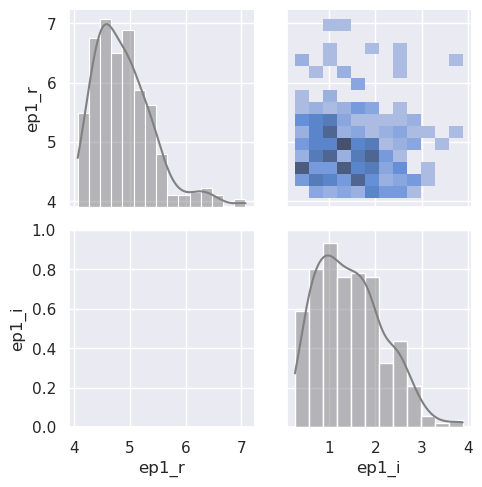

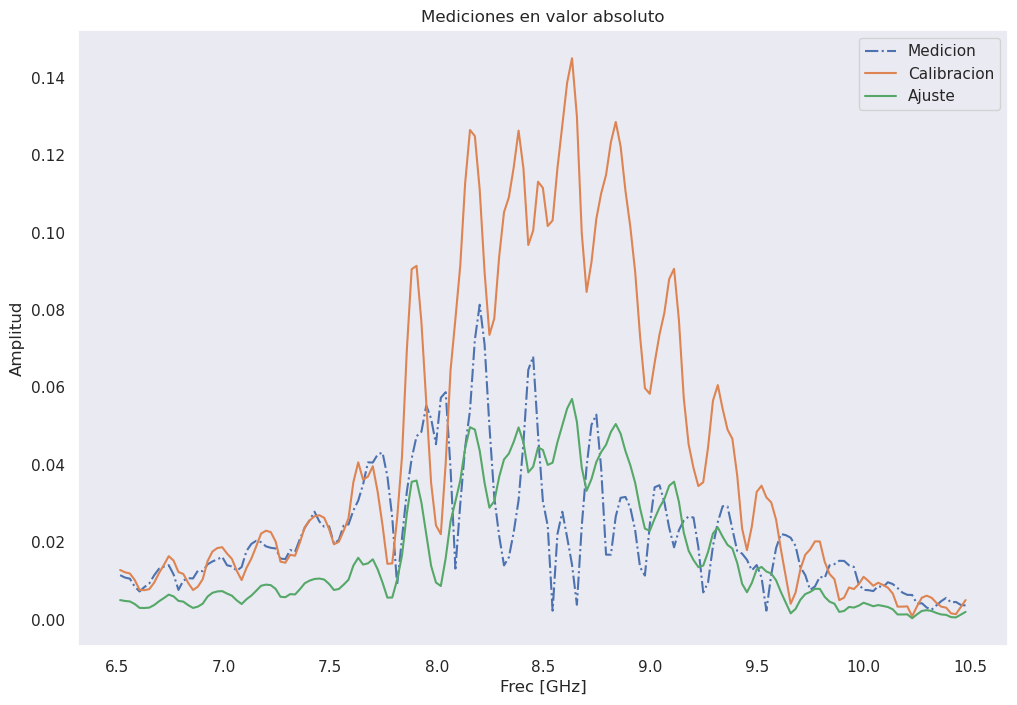

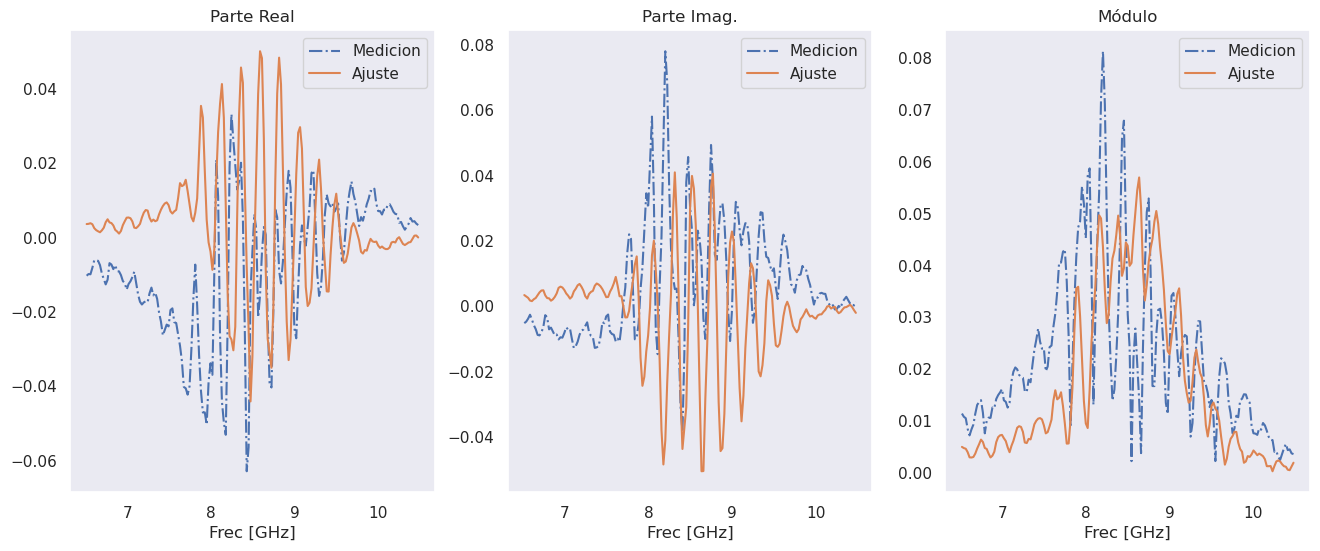

-------------------
Corro bayes para modelo liso --> med1
-------------------
Ruido :  0.0225
Muestras :  50



Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.125
Stage:   1 Beta: 0.477
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.121
Stage:   1 Beta: 0.473
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.141
Stage:   1 Beta: 0.751
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.102
Stage:   1 Beta: 0.458
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.117
Stage:   1 Beta: 0.500
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.109
Stage:   1 Beta: 0.523
Stage:   2 Beta: 1.000


Tiempo insumido - Inf. Bayesiana: 5.33 seg (0.09 min)
Graficando para una capa de dielectrico liso sobre conductor ...


input ep1_r:  7.367
output ep1_r:  5.86 +/- 1.031

input ep1_i:  0.70206
output ep1_i:  2.249 +/- 1.183

Tiempo insumido - Graficos: 0.6 seg (0.01 min)

Tiempo insumido - TOTAL: 5.93 seg (0.1 min)





/home/gordotony/anaconda3/envs/UWB/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


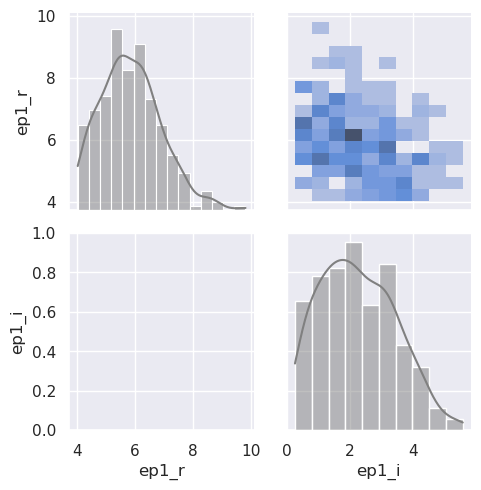

KeyboardInterrupt: 

In [54]:
for i0 in range(7):
    Star = S2[:,i0]

    print('-------------------')
    print('Corro bayes para modelo liso --> med'+str(i0))
    print('-------------------')
    t0 = time.time()
    # nro de muestras que va a utilizar el método
    muestras = 50
    noise_level = 2.25e-2
    # error de la medición
    sigmas = noise_level*np.ones((1,len(Star)))

    print('Ruido : ',noise_level)
    print('Muestras : ',muestras)
    print()

    # inferencia bayesiana
    traza_sim_cond_liso = modelo_l7(Star,muestras,sigmas,rug=False)

    t1 = time.time()
    print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')

    #Ploteo
    t2 = time.time()
    print('Graficando para una capa de dielectrico liso sobre conductor ...')
    print()

    ep1_r_mean = round(np.mean(traza_sim_cond_liso['ep1_r']),3)
    ep1_r_std = round(np.std(traza_sim_cond_liso['ep1_r']),3)

    ep1_i_mean = round(np.mean(traza_sim_cond_liso['ep1_i']),3)
    ep1_i_std = round(np.std(traza_sim_cond_liso['ep1_i']),3)


    plotear = np.stack((traza_sim_cond_liso['ep1_r'], traza_sim_cond_liso['ep1_i'])).T 
    dfplotear = pd.DataFrame(plotear, columns = ['ep1_r','ep1_i'])

    g = sns.PairGrid(dfplotear)
    g.map_upper(sns.histplot)
    g.map_diag(sns.histplot, kde=True, color='.5')
    g.savefig('outputs/L7/bayes-liso-med'+str(i0)+'.png')

    print()
    print('input ep1_r: ', np.real(ep_med[i0]))
    print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std))
    print()
    print('input ep1_i: ', np.imag(ep_med[i0]))
    print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std))
    print()
    t3 = time.time()
    print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)')
    print()

    print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)')
    print()
    print()
    print()

#-----------------------------
    EP1 = ep1_r_mean + 1j*ep1_i_mean
    S_fit = Scal*R_ep_cond(EP1,d,f_pos)

    plt.figure(figsize=(12,8))
    plt.plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
    plt.plot(f_pos/1e9,np.abs(Scal),label="Calibracion")
    plt.plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
    plt.grid()
    plt.xlabel('Frec [GHz]')
    plt.ylabel('Amplitud')
    plt.title('Mediciones en valor absoluto')
    plt.legend(loc="best")
    plt.savefig('outputs/L7/fig-liso-med'+str(i0)+'.png')

#----------------------------------

    with open('outputs/L7/datos-liso-med'+str(i0)+'.txt', 'w') as f:
        print('-------------------', file=f)
        print('Incidencia en un dielectrico sin rugosidad sobre conductor ideal', file=f)
        print('-------------------', file=f)
        print('', file=f)
        print('-------------------', file=f)
        print('Corro bayes', file=f)
        print('-------------------', file=f)
        print('Ruido : ',noise_level, file=f)
        print('Muestras : ',muestras, file=f)
        print('', file=f)
        print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)', file=f)
        print('', file=f)
        print('Valores obtenidos:', file=f)
        print('input ep1_r: ', np.real(ep_med[i0]), file=f)
        print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std), file=f)
        print('', file=f)
        print('input ep1_i: ', round(np.imag(ep_med[i0]),3), file=f)
        print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std), file=f)
        print('', file=f)
        print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)', file=f)
        print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)', file=f)
        print('', file=f)
        print('', file=f)
    f.close()

#----------------------------------
    fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
    ax[0].plot(f_pos/1e9,np.real(Star),'-.',label="Medicion")
    ax[0].plot(f_pos/1e9,np.real(S_fit),label="Ajuste")
    ax[0].grid()
    ax[0].set_xlabel('Frec [GHz]')
    ax[0].set_title('Parte Real')
    ax[0].legend(loc="best")

    ax[1].plot(f_pos/1e9,np.imag(Star),'-.',label="Medicion")
    ax[1].plot(f_pos/1e9,np.imag(S_fit),label="Ajuste")
    ax[1].grid()
    ax[1].set_xlabel('Frec [GHz]')
    ax[1].set_title('Parte Imag.')
    ax[1].legend(loc="best")

    ax[2].plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
    ax[2].plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
    ax[2].grid()
    ax[2].set_xlabel('Frec [GHz]')
    ax[2].set_title('Módulo')
    ax[2].legend(loc="best")
    plt.savefig('outputs/L7/partes-liso-med'+str(i0)+'.png')
    plt.show()


-------------------
Corro bayes para modelo rugoso --> med0
-------------------
Ruido :  0.0225
Muestras :  5000



Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.067
Stage:   1 Beta: 0.221
Stage:   2 Beta: 0.782
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.068
Stage:   1 Beta: 0.221
Stage:   2 Beta: 0.754
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.067
Stage:   1 Beta: 0.220
Stage:   2 Beta: 0.755
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.067
Stage:   1 Beta: 0.217
Stage:   2 Beta: 0.764
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.068
Stage:   1 Beta: 0.225
Stage:   2 Beta: 0.759
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.068
Stage:   1 Beta: 0.224
Stage:   2 Beta: 0.791
Stage:   3 Beta: 1.000


Tiempo insumido - Inf. Bayesiana: 90.32 seg (1.51 min)
Graficando para una capa de dielectrico rugoso sobre conductor ...


input ep1_r:  7.5172
output ep1_r:  4.78 +/- 0.573

input ep1_i:  0.67952
output ep1_i:  1.416 +/- 0.747

input s1: ---
output s1:  5e-05 +/- 2.7e-05

Tiempo insumido - Graficos: 1.65 seg (0.03 min)

Tiempo insumido - TOTAL: 91.97 seg (1.53 min)





/home/gordotony/anaconda3/envs/UWB/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


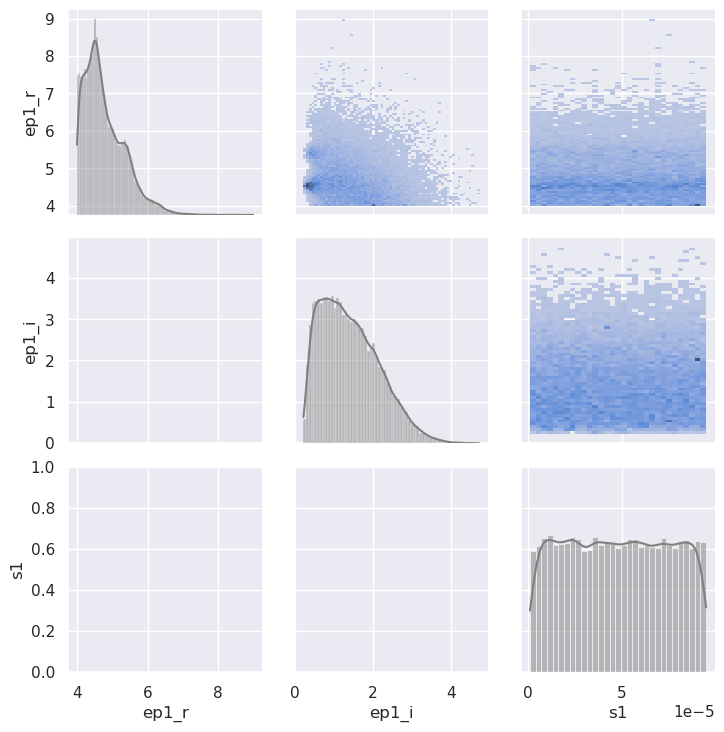

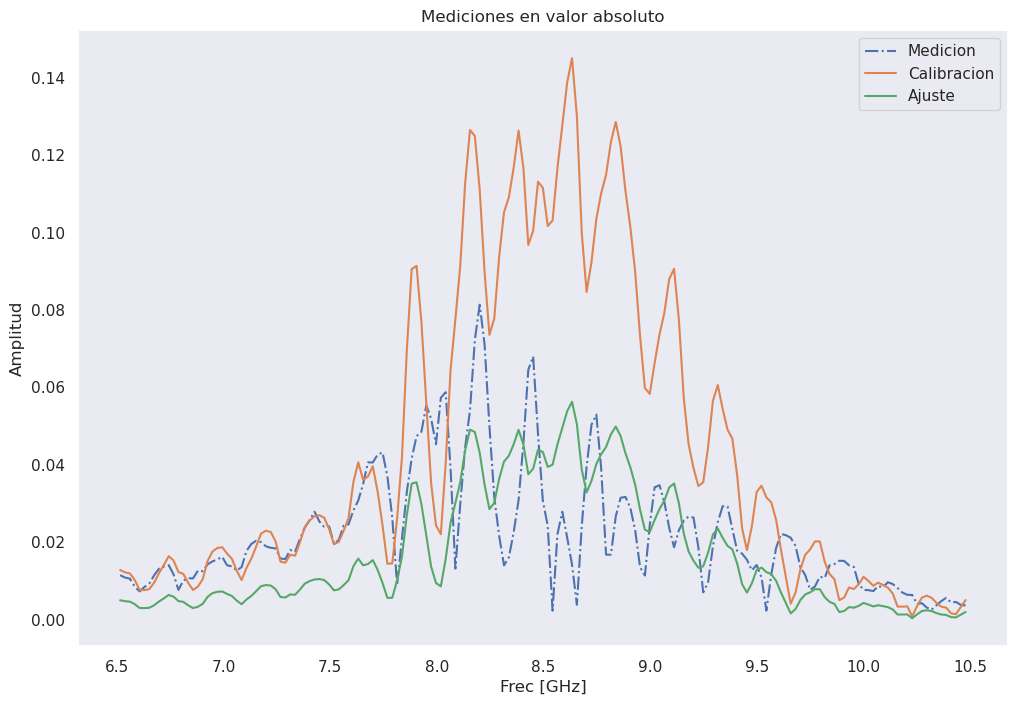

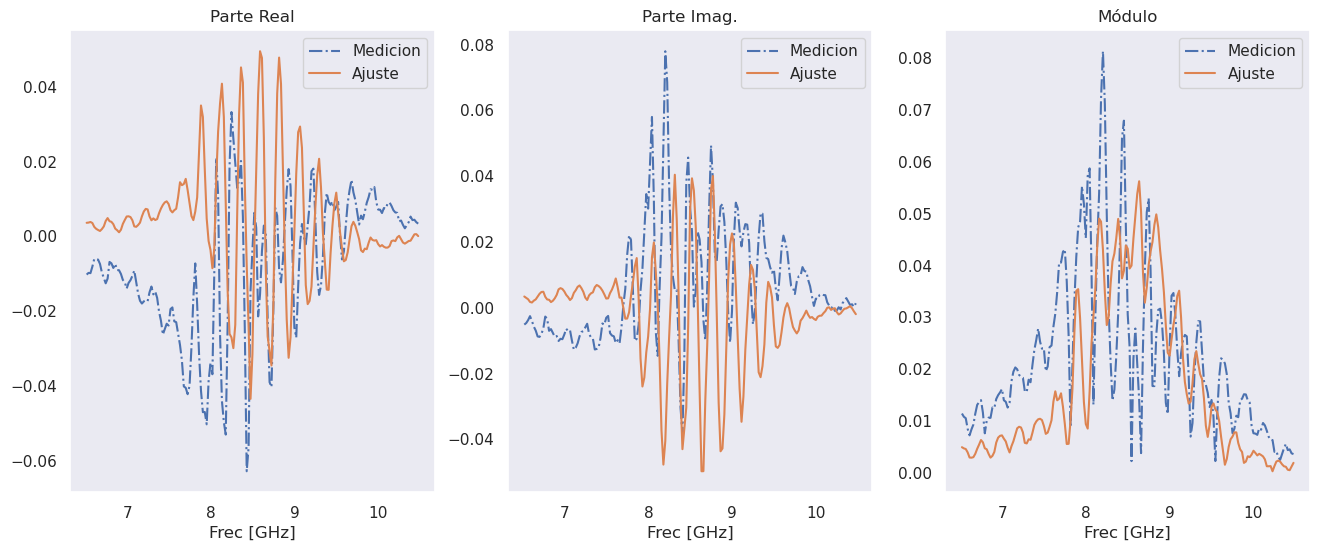

-------------------
Corro bayes para modelo rugoso --> med1
-------------------
Ruido :  0.0225
Muestras :  5000



Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.117
Stage:   1 Beta: 0.526
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.117
Stage:   1 Beta: 0.536
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.118
Stage:   1 Beta: 0.524
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.117
Stage:   1 Beta: 0.535
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.119
Stage:   1 Beta: 0.537
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.120
Stage:   1 Beta: 0.556
Stage:   2 Beta: 1.000


Tiempo insumido - Inf. Bayesiana: 84.72 seg (1.41 min)
Graficando para una capa de dielectrico rugoso sobre conductor ...


input ep1_r:  7.367
output ep1_r:  5.851 +/- 1.089

input ep1_i:  0.70206
output ep1_i:  2.111 +/- 1.242

input s1: ---
output s1:  5e-05 +/- 2.7e-05

Tiempo insumido - Graficos: 1.73 seg (0.03 min)

Tiempo insumido - TOTAL: 86.45 seg (1.44 min)





/home/gordotony/anaconda3/envs/UWB/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


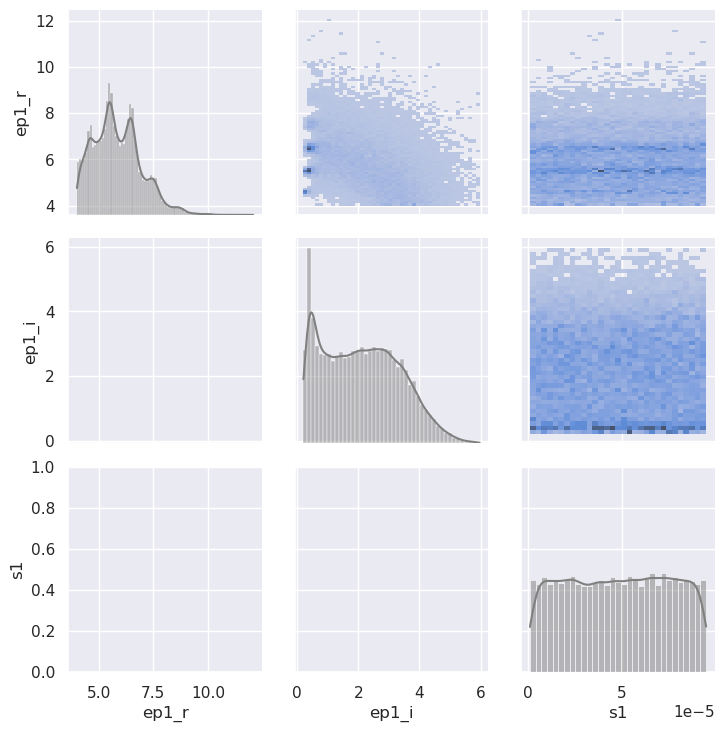

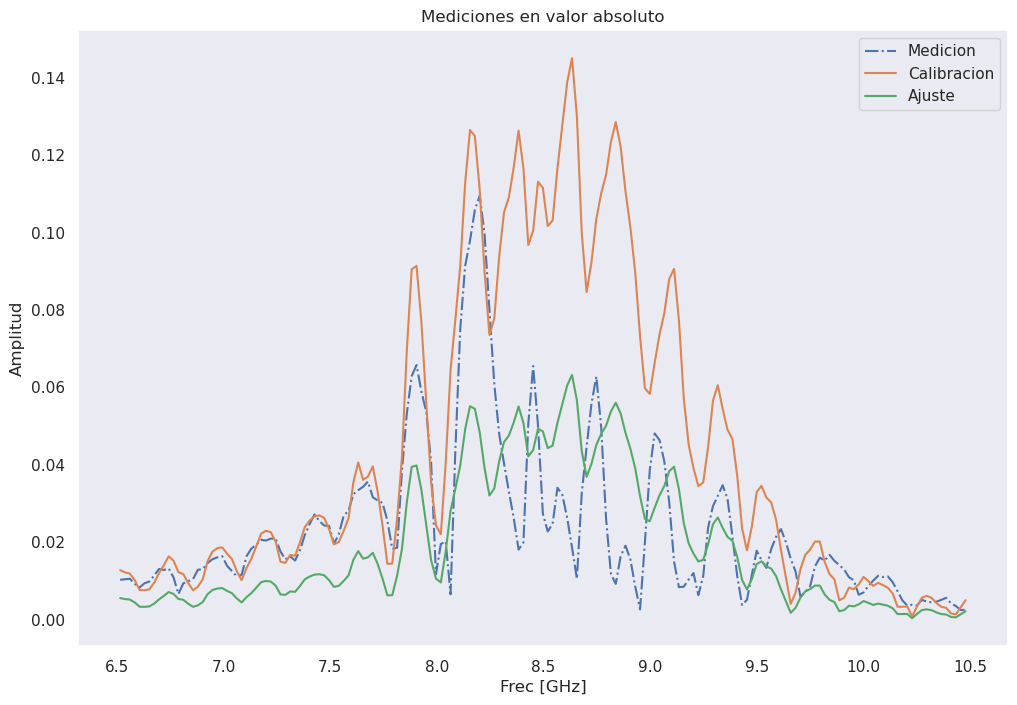

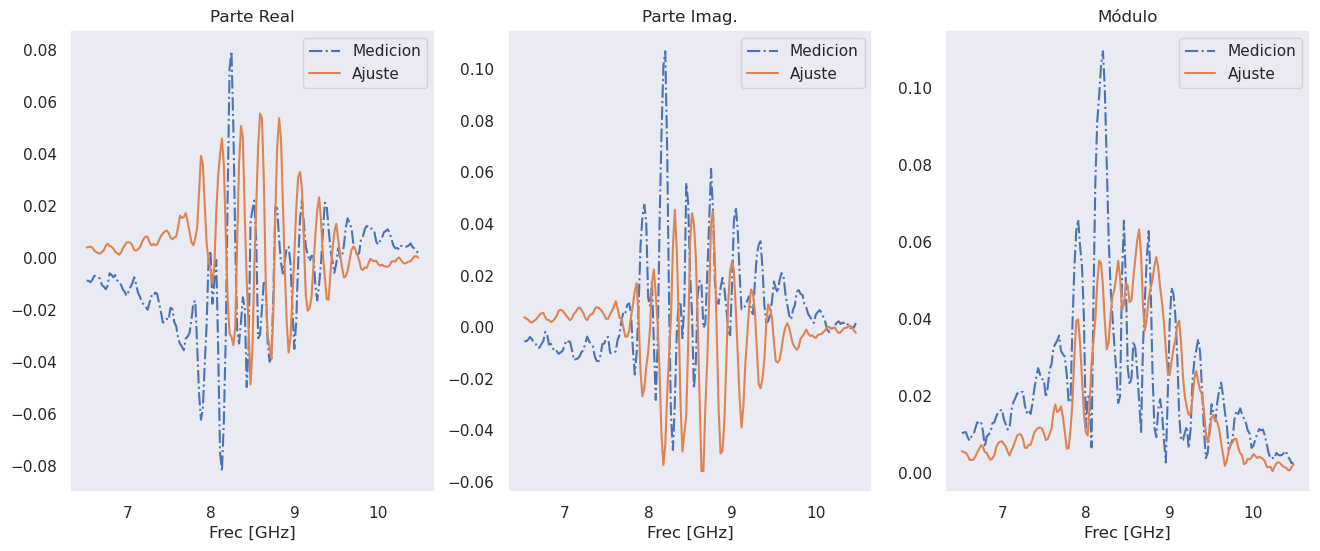

-------------------
Corro bayes para modelo rugoso --> med2
-------------------
Ruido :  0.0225
Muestras :  5000



Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.137
Stage:   1 Beta: 0.649
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.136
Stage:   1 Beta: 0.668
Stage:   2 Beta: 1.000


KeyboardInterrupt: 

In [55]:
for i0 in range(7):
    Star = S2[:,i0]

    print('-------------------')
    print('Corro bayes para modelo rugoso --> med'+str(i0))
    print('-------------------')
    t0 = time.time()
    # nro de muestras que va a utilizar el método
    muestras = 5000
    noise_level = 2.25e-2
    # error de la medición
    sigmas = noise_level*np.ones((1,len(Star)))

    print('Ruido : ',noise_level)
    print('Muestras : ',muestras)
    print()

    # inferencia bayesiana
    traza_sim_cond_rug = modelo_l7(Star,muestras,sigmas,rug=True)

    t1 = time.time()
    print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')

    #Ploteo
    t2 = time.time()
    print('Graficando para una capa de dielectrico rugoso sobre conductor ...')
    print()

    ep1_r_mean = round(np.mean(traza_sim_cond_rug['ep1_r']),3)
    ep1_r_std = round(np.std(traza_sim_cond_rug['ep1_r']),3)

    ep1_i_mean = round(np.mean(traza_sim_cond_rug['ep1_i']),3)
    ep1_i_std = round(np.std(traza_sim_cond_rug['ep1_i']),3)

    s1_mean = round(np.mean(traza_sim_cond_rug['s1']),5)
    s1_std = round(np.std(traza_sim_cond_rug['s1']),6)


    plotear = np.stack((traza_sim_cond_rug['ep1_r'],traza_sim_cond_rug['ep1_i'],traza_sim_cond_rug['s1'])).T 
    dfplotear = pd.DataFrame(plotear, columns = ['ep1_r','ep1_i','s1'])

    g = sns.PairGrid(dfplotear)
    g.map_upper(sns.histplot)
    g.map_diag(sns.histplot, kde=True, color='.5')
    g.savefig('outputs/L7/bayes-rug-med'+str(i0)+'.png')

    print()
    print('input ep1_r: ', np.real(ep_med[i0]))
    print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std))
    print()
    print('input ep1_i: ', np.imag(ep_med[i0]))
    print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std))
    print()
    print('input s1: ---')
    print('output s1: ', str(s1_mean)+" +/- "+str(s1_std))
    print()
    t3 = time.time()
    print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)')
    print()

    print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)')
    print()
    print()
    print()

#-----------------------------
    EP1 = ep1_r_mean + 1j*ep1_i_mean
    S1_opt = s1_mean

    S_fit = Scal*Rf_espejo(EP1,d,f_pos,S1_opt)

    plt.figure(figsize=(12,8))
    plt.plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
    plt.plot(f_pos/1e9,np.abs(Scal),label="Calibracion")
    plt.plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
    plt.grid()
    plt.xlabel('Frec [GHz]')
    plt.ylabel('Amplitud')
    plt.title('Mediciones en valor absoluto')
    plt.legend(loc="best")
    plt.savefig('outputs/L7/fig-rug-med'+str(i0)+'.png')

#----------------------------------

    with open('outputs/L7/datos-rug-med'+str(i0)+'.txt', 'w') as f:
        print('-------------------', file=f)
        print('Incidencia en un dielectrico con rugosidad sobre conductor ideal', file=f)
        print('-------------------', file=f)
        print('', file=f)
        print('-------------------', file=f)
        print('Corro bayes', file=f)
        print('-------------------', file=f)
        print('Ruido : ',noise_level, file=f)
        print('Muestras : ',muestras, file=f)
        print('', file=f)
        print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)', file=f)
        print('', file=f)
        print('Valores obtenidos:', file=f)
        print('input ep1_r: ', np.real(ep_med[i0]), file=f)
        print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std), file=f)
        print('', file=f)
        print('input ep1_i: ', round(np.imag(ep_med[i0]),3), file=f)
        print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std), file=f)
        print('', file=f)
        print('input s1: ---', file=f)
        print('output s1: ', str(s1_mean)+" +/- "+str(s1_std), file=f)
        print('', file=f)
        print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)', file=f)
        print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)', file=f)
        print('', file=f)
        print('', file=f)
    f.close()

#----------------------------------
    fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
    ax[0].plot(f_pos/1e9,np.real(Star),'-.',label="Medicion")
    ax[0].plot(f_pos/1e9,np.real(S_fit),label="Ajuste")
    ax[0].grid()
    ax[0].set_xlabel('Frec [GHz]')
    ax[0].set_title('Parte Real')
    ax[0].legend(loc="best")

    ax[1].plot(f_pos/1e9,np.imag(Star),'-.',label="Medicion")
    ax[1].plot(f_pos/1e9,np.imag(S_fit),label="Ajuste")
    ax[1].grid()
    ax[1].set_xlabel('Frec [GHz]')
    ax[1].set_title('Parte Imag.')
    ax[1].legend(loc="best")

    ax[2].plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
    ax[2].plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
    ax[2].grid()
    ax[2].set_xlabel('Frec [GHz]')
    ax[2].set_title('Módulo')
    ax[2].legend(loc="best")
    plt.savefig('outputs/L7/partes-rug-med'+str(i0)+'.png')
    plt.show()

    